# Multiple Detections & False Positives
Here are six consecutive frames from the project video and I'm showing all the bounding boxes for where my classifier reported positive detections. You can see that overlapping detections exist for each of the two vehicles, and in two of the frames, I find a false positive detection on the guardrail to the left. In this exercise, you'll build a heat-map from these detections in order to combine overlapping detections and remove false positives.

![screen-shot-2017-01-29-at-2.52.00-pm.png](./img/screen-shot-2017-01-29-at-2.52.00-pm.png)
To make a heat-map, you're simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by your classifier. The individual heat-maps for the above images look like this:
![screen-shot-2017-01-29-at-7.11.18-pm.png](./img/screen-shot-2017-01-29-at-7.11.18-pm.png)

In the exercise below, you are provided with a list of bounding boxes for the detections in the images shown above. Rather than consider heat-maps for each individual image, you'll write a function that adds "heat" to a map for a list of bounding boxes.
```python
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
```
If your classifier is working well, then the "hot" parts of the map are where the cars are, and by imposing a threshold, you can reject areas affected by false positives. So let's write a function to threshold the map as well.
```python
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
```
In practice, you will want to integrate a heat map over several frames of video, such that areas of multiple detections get "hot", while transient false positives stay "cool". You can then simply threshold your heatmap to remove false positives.

Once you have a thresholded heat-map, there are many ways you could go about trying to figure out how many cars you have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the `label()` function from `scipy.ndimage.measurements`. You'll use it like this:
```python
from scipy.ndimage.measurements import label
labels = label(heatmap)
```
Now `labels` is a 2-tuple, where the first item is an array the size of the `heatmap` input image and the second element is the number of labels (cars) found.

In the above series of images the same false positive window appeared twice, so if I set a threshold of 2 (meaning set all values <= 2 to 0) and then run the `labels`() function. I get a result that 2 cars were identified (the two islands in the heat-map) and the labeled image where pixels are set to 0 for background, 1 for car number 1, and 2 for car number 2.
```python
heatmap = threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
```

**2 cars found**

![found2car.png](./img/found2car.png)

Next, you can take your `labels` image and put bounding boxes around the labeled regions. You could do this in the following manner:
```python
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in the last image above
image = mpimg.imread('img105.jpg')
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)
```
**And the output looks like this:**
![example_result.png](./img/example_result.png)

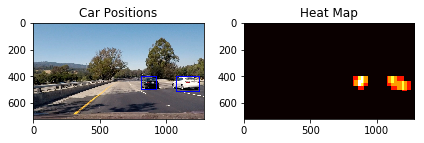

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
%matplotlib inline

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('./img/test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()